In [1]:

import datetime
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf
from scipy import signal
import bokeh
import seaborn as sns
from matplotlib import rcParams
%matplotlib inline
plt.style.use('default')
rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded and editable
rcParams['ps.fonttype'] = 42  # Ensure compatibility with vector outputs


def bokeh_plotter(data_list, x_axis_list=None, label_list=None,
                  plot_name='default',
                  x_axis_label='X', y_axis_label='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis_label,
                                y_axis_label=y_axis_label,
                                plot_width=1500,
                                plot_height=700)

    for i, data_vector in enumerate(data_list):

        color = next(color_cycle)

        if x_axis_list is None:
            x_axis = range(len(data_vector))
        elif len(x_axis_list) == len(data_list):
            print('x_axis manually set')
            x_axis = x_axis_list[i]
        else:
            raise Exception('problem with x_axis_list input - should be either None, or a list with the same length as data_list')
        if label_list is None:
            fig.line(x_axis, data_vector, line_color=color, legend_label=f"Line {i+1}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)


def load_eye_data_2d_w_rotation_matrix(block):
    """
    This function checks if the eye dataframes and rotation dict object exist, then imports them
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    try:
        block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0, engine='python')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0, engine='python')
    except FileNotFoundError:
        print('eye_data files not found, run the pipeline!')
        return

    try:
        with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'rb') as file:
            rotation_dict = pickle.load(file)
            block.left_rotation_matrix = rotation_dict['left_rotation_matrix']
            block.right_rotation_matrix = rotation_dict['right_rotation_matrix']
            block.left_rotation_angle = rotation_dict['left_rotation_angle']
            block.right_rotation_angle = rotation_dict['right_rotation_angle']
    except FileNotFoundError:
        print('No rotation matrix file, create it')


def create_saccade_events_df(eye_data_df, speed_threshold, bokeh_verify_threshold=False, magnitude_calib=1, speed_profile=True):
    """
    Detects saccade events in eye tracking data and computes relevant metrics.

    Parameters:
    - eye_data_df (pd.DataFrame): Input DataFrame containing eye tracking data.
    - speed_threshold (float): Threshold for saccade detection based on speed.

    Returns:
    - df (pd.DataFrame): Modified input DataFrame with added columns for speed and saccade detection.
    - saccade_events_df (pd.DataFrame): DataFrame containing information about detected saccade events.

    Steps:
    1. Calculate speed components ('speed_x', 'speed_y') based on differences in 'center_x' and 'center_y'.
    2. Compute the magnitude of the velocity vector ('speed_r').
    3. Create a binary column ('is_saccade') indicating saccade events based on the speed threshold.
    4. Determine saccade onset and offset indices and timestamps.
    5. Create a DataFrame ('saccade_events_df') with columns:
        - 'saccade_start_ind': Indices of saccade onset.
        - 'saccade_start_timestamp': Timestamps corresponding to saccade onset.
        - 'saccade_end_ind': Indices of saccade offset.
        - 'saccade_end_timestamp': Timestamps corresponding to saccade offset.
        - 'length': Duration of each saccade event.
    6. Calculate distance traveled and angles for each saccade event.
    7. Append additional columns to 'saccade_events_df':
        - 'magnitude': Magnitude of the distance traveled during each saccade.
        - 'angle': Angle of the saccade vector in degrees.
        - 'initial_x', 'initial_y': Initial coordinates of the saccade.
        - 'end_x', 'end_y': End coordinates of the saccade.

    Note: The original 'eye_data_df' is not modified; modified data is returned as 'df'.
    """
    df = eye_data_df
    df['speed_x'] = df['center_x'].diff()  # Difference between consecutive 'center_x' values
    df['speed_y'] = df['center_y'].diff()  # Difference between consecutive 'center_y' values

    # Step 2: Calculate magnitude of the velocity vector (R vector speed)
    df['speed_r'] = (df['speed_x']**2 + df['speed_y']**2)**0.5

    # Create a column for saccade detection
    df['is_saccade'] = df['speed_r'] > speed_threshold

    # create a saccade_on_off indicator where 1 is rising edge and -1 is falling edge by subtracting a shifted binary mask
    saccade_on_off = df.is_saccade.astype(int) - df.is_saccade.shift(periods=1,fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[0] - 1 # notice the manual shift here, chosen to include the first (sometimes slower) eye frame, just before saccade threshold crossing
    saccade_on_ms = df['ms_axis'].iloc[saccade_on_inds]
    saccade_on_timestamps = df['OE_timestamp'].iloc[saccade_on_inds]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]
    saccade_off_timestamps = df['OE_timestamp'].iloc[saccade_off_inds]
    saccade_off_ms = df['ms_axis'].iloc[saccade_off_inds]

    saccade_dict = {'saccade_start_ind' :  saccade_on_inds ,
                    'saccade_start_timestamp': saccade_on_timestamps.values,
                    'saccade_end_ind':      saccade_off_inds,
                    'saccade_end_timestamp':saccade_off_timestamps.values,
                    'saccade_on_ms': saccade_on_ms.values,
                    'saccade_off_ms': saccade_off_ms.values}

    saccade_events_df = pd.DataFrame.from_dict(saccade_dict)
    saccade_events_df['length'] = saccade_events_df['saccade_end_ind'] - saccade_events_df['saccade_start_ind']
    # Drop columns used for intermediate steps
    df = df.drop(['is_saccade'], axis=1)

    distances = []
    angles = []
    speed_list = []
    speed_list_calib = []
    diameter_list = []
    for index, row in tqdm.tqdm(saccade_events_df.iterrows()):
        saccade_samples = df.loc[(df['OE_timestamp'] >= row['saccade_start_timestamp']) &
                                 (df['OE_timestamp'] <= row['saccade_end_timestamp'])]
        distance_traveled = saccade_samples['speed_r'].sum()
        if speed_profile:
            saccade_speed_profile = saccade_samples['speed_r'].values
            saccade_calib_speed_profile = saccade_samples['speed_r'].values * magnitude_calib
            speed_list.append(saccade_speed_profile)
            speed_list_calib.append(saccade_calib_speed_profile)
        saccade_diameter_profile = saccade_samples['pupil_diameter'].values
        diameter_list.append(saccade_diameter_profile)
        # Calculate angle from initial position to endpoint
        initial_position = saccade_samples.iloc[0][['center_x', 'center_y']]
        endpoint = saccade_samples.iloc[-1][['center_x', 'center_y']]
        overall_angle = np.arctan2(endpoint['center_y'] - initial_position['center_y'],
                           endpoint['center_x'] - initial_position['center_x'])

        angles.append(overall_angle)
        distances.append(distance_traveled)



    saccade_events_df['magnitude_raw'] = np.array(distances)
    saccade_events_df['magnitude'] = np.array(distances) * magnitude_calib
    saccade_events_df['angle'] = np.where(np.isnan(angles), angles, np.rad2deg(angles) % 360) # Convert radians to degrees and ensure result is in [0, 360)
    start_ts = saccade_events_df['saccade_start_timestamp'].values
    end_ts = saccade_events_df['saccade_end_timestamp'].values
    saccade_start_df = df[df['OE_timestamp'].isin(start_ts)]
    saccade_end_df = df[df['OE_timestamp'].isin(end_ts)]
    start_x_coord = saccade_start_df['center_x']
    start_y_coord = saccade_start_df['center_y']
    end_x_coord = saccade_end_df['center_x']
    end_y_coord = saccade_end_df['center_y']
    saccade_events_df['initial_x'] = start_x_coord.values
    saccade_events_df['initial_y'] = start_y_coord.values
    saccade_events_df['end_x'] = end_x_coord.values
    saccade_events_df['end_y'] = end_y_coord.values
    saccade_events_df['calib_dx'] = (saccade_events_df['end_x'].values - saccade_events_df['initial_x'].values) * magnitude_calib
    saccade_events_df['calib_dy'] = (saccade_events_df['end_y'].values - saccade_events_df['initial_y'].values) * magnitude_calib
    if speed_profile:
        saccade_events_df['speed_profile'] = speed_list
        saccade_events_df['speed_profile_calib'] = speed_list_calib
    saccade_events_df['diameter_profile'] = diameter_list
    if bokeh_verify_threshold:
        bokeh_plotter(data_list=[df.speed_r], label_list=['Pupil Velocity'], peaks=saccade_on_inds)

    return df, saccade_events_df

# create a multi-animal block_collection:

def create_block_collections(animals, block_lists, experiment_path, bad_blocks=None):
    """
    Create block collections and a block dictionary from multiple animals and their respective block lists.

    Parameters:
    - animals: list of str, names of the animals.
    - block_lists: list of lists of int, block numbers corresponding to each animal.
    - experiment_path: pathlib.Path, path to the experiment directory.
    - bad_blocks: list of int, blocks to exclude. Default is an empty list.

    Returns:
    - block_collection: list of BlockSync objects for all specified blocks.
    - block_dict: dictionary where keys are block numbers as strings and values are BlockSync objects.
    """
    import UtilityFunctions_newOE as uf

    if bad_blocks is None:
        bad_blocks = []

    block_collection = []
    block_dict = {}

    for animal, blocks in zip(animals, block_lists):
        # Generate blocks for the current animal
        current_blocks = uf.block_generator(
            block_numbers=blocks,
            experiment_path=experiment_path,
            animal=animal,
            bad_blocks=bad_blocks
        )
        # Add to collection and dictionary
        block_collection.extend(current_blocks)
        for b in current_blocks:
            block_dict[f"{animal}_block_{b.block_num}"] = b

    return block_collection, block_dict


In [2]:
animals = ['PV_62','PV_126','PV_57']
block_lists = [[24,26,38],[7,8,9,10,11,12],[7,8,9,12,13]]
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
bad_blocks = [0]  # Example of bad blocks

block_collection, block_dict = create_block_collections(
    animals=animals,
    block_lists=block_lists,
    experiment_path=experiment_path,
    bad_blocks=bad_blocks)

instantiated block number 024 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_024, new OE version
Found the sample rate for block 024 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 024
got it!
instantiated block number 026 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_026, new OE version
Found the sample rate for block 026 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 026
got it!
instantiated block number 038 at Path: Z:\Nimrod\experiments\PV_62\2023_05_01\block_038, new OE version
Found the sample rate for block 038 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 038
got it!
instantiated block number 007 at Path: Z:\Nimrod\experi

In [3]:
for block in block_collection:
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)

    # if the code fails here, go to manual synchronization
    block.import_manual_sync_df()
    block.read_dlc_data()
    block.calibrate_pixel_size(10)
    load_eye_data_2d_w_rotation_matrix(block) #should be integrated again... later

# # NOTICE THE DIRECTIONALITY FLIP!!!
#     block.left_eye_data = horizontal_flip_eye_data(block.left_eye_data.copy(),640)
#     block.right_eye_data = horizontal_flip_eye_data(block.right_eye_data.copy(),640)
    # calibrate pupil diameter:
for block in block_collection:
    block.left_eye_data = pd.read_csv(block.analysis_path / f'left_eye_data_degrees_raw_verified.csv')
    block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data_degrees_raw_verified.csv')


running parse_open_ephys_events...
block 024 has a parsed events file, reading...
Getting eye brightness values for block 024...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 026 has a parsed events file, reading...
Getting eye brightness values for block 026...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 038 has a parsed events file, reading...
Getting eye brightness values for block 038...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_

In [4]:
 for block in block_collection:
    if 'pupil_diameter' not in block.left_eye_data.columns:
        block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax
        block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax
        block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
        block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size

In [5]:
# Now make a function to update saccade detection:
import numpy as np
import pandas as pd


def create_saccade_events_with_direction_segmentation_updated(
        eye_data_df,
        speed_threshold,  # angular speed threshold in degrees/frame
        directional_delta_threshold_deg=15,  # threshold for change in instantaneous angle (degrees)
        magnitude_calib=1,
        speed_profile=True,
        min_subsaccade_samples=2
):
    """
    Detects saccade events using an angular speed threshold (degrees/frame) and
    segments them based on directional shifts computed from the angular (k_phi/k_theta)
    data. This function computes both pixel-based metrics (from center_x/center_y) and
    angular-based metrics (from k_phi/k_theta) for comparison.

    Parameters:
      - eye_data_df (pd.DataFrame): Input DataFrame with columns including:
            'center_x', 'center_y', 'k_phi', 'k_theta', 'OE_timestamp', 'ms_axis',
            and 'pupil_diameter'.
      - speed_threshold (float): Angular speed threshold (in degrees/frame) for saccade detection.
      - directional_delta_threshold_deg (float): Threshold (in degrees) for the instantaneous angle change
            that defines a segmentation boundary within a saccade.
      - magnitude_calib (float): Calibration factor to convert pixel-based speeds to millimeters.
            Not applied to the angular data.
      - speed_profile (bool): Whether to record speed profiles.
      - min_subsaccade_samples (int): Minimum number of samples required for a valid subsaccade.

    Returns:
      - df (pd.DataFrame): The input DataFrame with additional computed columns.
      - saccade_events_df (pd.DataFrame): A DataFrame listing detected and segmented saccade events,
            with both pixel-derived and angular-derived metrics.
    """
    # Make a copy to avoid modifying the original DataFrame
    df = eye_data_df.copy()

    ### 1. Compute Frame-to-Frame Differences
    # -- Pixel-based differences
    df["speed_x"] = df["center_x"].diff()
    df["speed_y"] = df["center_y"].diff()
    df["speed_r"] = np.sqrt(df["speed_x"] ** 2 + df["speed_y"] ** 2)

    # -- Angular-based differences (k_phi and k_theta are in degrees)
    df["angular_speed_phi"] = df["k_phi"].diff()
    df["angular_speed_theta"] = df["k_theta"].diff()
    df["angular_speed_r"] = np.sqrt(df["angular_speed_phi"] ** 2 + df["angular_speed_theta"] ** 2)

    ### 2. Saccade Detection Based on Angular Speed
    # Flag candidate saccade samples using the angular speed threshold (degrees/frame)
    df["is_saccade_angle"] = df["angular_speed_r"] > speed_threshold

    # Determine saccade onsets and offsets (using angular speed based flag)
    saccade_on_off = df["is_saccade_angle"].astype(int) - df["is_saccade_angle"].shift(1, fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[0] - 1  # include one frame before threshold crossing
    saccade_off_inds = np.where(saccade_on_off == -1)[0]

    # Handle possible mismatches in start/end indices
    if len(saccade_on_inds) > len(saccade_off_inds):
        if len(saccade_on_inds) - len(saccade_off_inds) == 1:
            print("Detected unmatched final saccade start index. Truncating last saccade start index.")
            saccade_on_inds = saccade_on_inds[:-1]
        else:
            raise ValueError("Mismatch between saccade start and end indices. Manual inspection required.")

    saccade_events = []

    ### 3. Process Each Detected Saccade for Segmentation
    for start_ind, end_ind in zip(saccade_on_inds, saccade_off_inds):
        saccade_df = df.iloc[start_ind:end_ind + 1].copy()
        if saccade_df.empty or len(saccade_df) < min_subsaccade_samples:
            continue

        # Compute instantaneous angles for each frame in the saccade.
        # -- Pixel-based instantaneous angle (derived from center_x/center_y differences)
        saccade_df["inst_angle_pixel"] = np.degrees(np.arctan2(saccade_df["speed_y"], saccade_df["speed_x"]))
        # -- Angular-based instantaneous angle (derived from k_phi/k_theta differences)
        saccade_df["inst_angle_deg"] = np.degrees(
            np.arctan2(saccade_df["angular_speed_theta"], saccade_df["angular_speed_phi"]))

        # Define an inline helper to compute minimal angular difference (in degrees)
        minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180

        # Compute differences between consecutive instantaneous angular-based angles (handling circularity)
        angles = saccade_df["inst_angle_deg"].values
        angle_diffs = np.array([minimal_angle_diff_deg(angles[i + 1], angles[i]) for i in range(len(angles) - 1)])

        # Identify candidate segmentation boundaries where the absolute difference exceeds the threshold
        candidate_boundaries = np.where(np.abs(angle_diffs) > directional_delta_threshold_deg)[0].tolist()

        # Always include the first and last sample as boundaries
        if not candidate_boundaries:
            boundaries = [0, len(saccade_df) - 1]
        else:
            boundaries = [0] + candidate_boundaries + [len(saccade_df) - 1]

        # Segment the saccade. Overlap boundaries so that the end of one segment is the start of the next.
        for i in range(len(boundaries) - 1):
            seg_start = boundaries[i]
            seg_end = boundaries[i + 1]
            subsaccade = saccade_df.iloc[seg_start: seg_end + 1]
            if len(subsaccade) < min_subsaccade_samples:
                continue

            # Timing and sample indices for this subsaccade
            sub_start_timestamp = subsaccade["OE_timestamp"].iloc[0]
            sub_end_timestamp = subsaccade["OE_timestamp"].iloc[-1]
            sub_start_ms = subsaccade["ms_axis"].iloc[0]
            sub_end_ms = subsaccade["ms_axis"].iloc[-1]
            sub_length = subsaccade.index[-1] - subsaccade.index[0]

            # Pixel-based magnitude (sum of speeds) with calibration
            magnitude_raw_pixel = subsaccade["speed_r"].sum()
            magnitude_pixel = magnitude_raw_pixel * magnitude_calib

            # Angular-based magnitude (in degrees, no calibration applied)
            magnitude_raw_angular = subsaccade["angular_speed_r"].sum()

            # Compute overall saccade angle for the segment:
            # -- Pixel-based overall angle (using center_x and center_y differences)
            initial_pos_pixel = subsaccade.iloc[0][["center_x", "center_y"]]
            final_pos_pixel = subsaccade.iloc[-1][["center_x", "center_y"]]
            overall_angle_pixel = (np.degrees(np.arctan2(
                final_pos_pixel["center_y"] - initial_pos_pixel["center_y"],
                final_pos_pixel["center_x"] - initial_pos_pixel["center_x"]
            )) % 360)

            # -- Angular-based overall angle (using k_phi and k_theta differences)
            initial_pos_angle = subsaccade.iloc[0][["k_phi", "k_theta"]]
            final_pos_angle = subsaccade.iloc[-1][["k_phi", "k_theta"]]
            overall_angle_deg = (np.degrees(np.arctan2(
                final_pos_angle["k_theta"] - initial_pos_angle["k_theta"],
                final_pos_angle["k_phi"] - initial_pos_angle["k_phi"]
            )) % 360)

            # Speed profiles for the segment
            speed_profile_pixel = subsaccade["speed_r"].values if speed_profile else None
            speed_profile_pixel_calib = (speed_profile_pixel * magnitude_calib) if speed_profile else None
            speed_profile_angular = subsaccade["angular_speed_r"].values if speed_profile else None
            diameter_profile = subsaccade["pupil_diameter"].values

            saccade_events.append({
                "saccade_start_ind": subsaccade.index[0],
                "saccade_end_ind": subsaccade.index[-1],
                "saccade_start_timestamp": sub_start_timestamp,
                "saccade_end_timestamp": sub_end_timestamp,
                "saccade_on_ms": sub_start_ms,
                "saccade_off_ms": sub_end_ms,
                "length": sub_length,
                "magnitude_raw_pixel": magnitude_raw_pixel,
                "magnitude_pixel": magnitude_pixel,
                "overall_angle_pixel": overall_angle_pixel,
                "magnitude_raw_angular": magnitude_raw_angular,
                "overall_angle_deg": overall_angle_deg,
                "speed_profile_pixel": speed_profile_pixel,
                "speed_profile_pixel_calib": speed_profile_pixel_calib,
                "speed_profile_angular": speed_profile_angular,
                "diameter_profile": diameter_profile,
                "theta_init_pos": initial_pos_angle['k_theta'],
                "theta_end_pos": final_pos_angle['k_theta'],
                "phi_init_pos": initial_pos_angle['k_phi'],
                "phi_end_pos": final_pos_angle['k_phi']
            })

    # Convert the list of saccade events into a DataFrame
    saccade_events_df = pd.DataFrame(saccade_events)

    # Optionally remove intermediate columns
    df.drop(["is_saccade_angle"], axis=1, inplace=True)
    # calculate delta theta and delta phi
    saccade_events_df['delta_theta'] = saccade_events_df['theta_end_pos'] - saccade_events_df['theta_init_pos']
    saccade_events_df['delta_phi'] = saccade_events_df['phi_end_pos'] - saccade_events_df['phi_init_pos']
    return df, saccade_events_df


In [6]:
for block in block_collection:
    print(block)
    block.left_eye_data, block.l_saccade_df = create_saccade_events_with_direction_segmentation_updated(
        block.left_eye_data,
        4,  # angular speed threshold in degrees/frame
        directional_delta_threshold_deg=35,  # threshold for change in instantaneous angle (degrees)
        magnitude_calib=1,
        speed_profile=True,
        min_subsaccade_samples=2)
    block.right_eye_data, block.r_saccade_df = create_saccade_events_with_direction_segmentation_updated(
        block.right_eye_data,
        4,  # angular speed threshold in degrees/frame
        directional_delta_threshold_deg=35,  # threshold for change in instantaneous angle (degrees)
        magnitude_calib=1,
        speed_profile=True,
        min_subsaccade_samples=2)


PV_62, block 024, on 2023-04-27_11-22-56
PV_62, block 026, on 2023-04-27_12-21-41
PV_62, block 038, on 2023-05-01_13-57-45
PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12
PV_126, block 008, on PV126_Trial16_wake4_2024-07-18_13-24-41
PV_126, block 009, on PV126_Trial18_wake5_2024-07-18_14-39-15
PV_126, block 010, on PV126_Trial19_wake6_2024-07-18_15-24-57
PV_126, block 011, on PV126_Trial115_eyeTracking_w7
PV_126, block 012, on PV126_Trial116_eyeTracking_h8
PV_57, block 007, on pv_57_day2_03_2024-11-25_15-28-31
PV_57, block 008, on pv_57_day2_05_2024-11-25_16-07-18
PV_57, block 009, on pv_57_day2_06_2024-11-25_16-25-35
PV_57, block 012, on PV_57_hunter_2_2024-12-01_16-08-39
PV_57, block 013, on PV_57_hunter_2_2024-12-01_16-34-43


In [7]:
import numpy as np
import pandas as pd

def filter_saccade_events(saccade_events_df, min_length=1, min_disp_threshold=0.1):
    """
    Filters saccade events based on the number of frames (length) and overall angular displacement.

    Parameters:
      - saccade_events_df: DataFrame produced by create_saccade_events_with_direction_segmentation_updated.
        It should include at least the following columns:
          'length', 'theta_init_pos', 'theta_end_pos', 'phi_init_pos', 'phi_end_pos',
          or alternatively 'delta_theta' and 'delta_phi'.
      - min_length: Minimum number of frames for a saccade event (default is 1).
      - min_disp_threshold: Minimum overall angular displacement (in degrees) required for an event.

    Returns:
      - filtered_df: A DataFrame containing only saccade events with length >= min_length
                     and overall displacement >= min_disp_threshold.
    """
    # Make a copy to avoid modifying the original dataframe.
    filtered_df = saccade_events_df.copy()

    # Ensure that we have the delta columns.
    if 'delta_theta' not in filtered_df.columns or 'delta_phi' not in filtered_df.columns:
        # Compute delta_theta and delta_phi from the initial and final positions.
        filtered_df['delta_theta'] = filtered_df['theta_end_pos'] - filtered_df['theta_init_pos']
        filtered_df['delta_phi'] = filtered_df['phi_end_pos'] - filtered_df['phi_init_pos']

    # Compute the overall angular displacement.
    filtered_df['overall_disp'] = np.sqrt(filtered_df['delta_theta']**2 + filtered_df['delta_phi']**2)

    # Filter out events with length below min_length and overall displacement below threshold.
    filtered_df = filtered_df[(filtered_df['length'] >= min_length) &
                              (filtered_df['overall_disp'] >= min_disp_threshold)]

    return filtered_df


for block in block_collection:
    print(f'{block} before = {len(block.l_saccade_df)+len(block.r_saccade_df)}')
    block.l_saccade_df = filter_saccade_events(block.l_saccade_df,min_length=1,min_disp_threshold=0.23)
    block.r_saccade_df = filter_saccade_events(block.r_saccade_df,min_length=1,min_disp_threshold=0.23)
    print(f'{block} after = {len(block.l_saccade_df)+len(block.r_saccade_df)}')

PV_62, block 024, on 2023-04-27_11-22-56 before = 527
PV_62, block 024, on 2023-04-27_11-22-56 after = 443
PV_62, block 026, on 2023-04-27_12-21-41 before = 485
PV_62, block 026, on 2023-04-27_12-21-41 after = 419
PV_62, block 038, on 2023-05-01_13-57-45 before = 969
PV_62, block 038, on 2023-05-01_13-57-45 after = 820
PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12 before = 734
PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12 after = 667
PV_126, block 008, on PV126_Trial16_wake4_2024-07-18_13-24-41 before = 359
PV_126, block 008, on PV126_Trial16_wake4_2024-07-18_13-24-41 after = 321
PV_126, block 009, on PV126_Trial18_wake5_2024-07-18_14-39-15 before = 119
PV_126, block 009, on PV126_Trial18_wake5_2024-07-18_14-39-15 after = 104
PV_126, block 010, on PV126_Trial19_wake6_2024-07-18_15-24-57 before = 157
PV_126, block 010, on PV126_Trial19_wake6_2024-07-18_15-24-57 after = 127
PV_126, block 011, on PV126_Trial115_eyeTracking_w7 before = 903
PV_126, block 011,

In [8]:
# add annotations for a joint dataframe:
for block in block_collection:
    block.r_saccade_df['eye'] = 'R'
    block.r_saccade_df['block'] = block.block_num
    block.r_saccade_df['animal'] = block.animal_call
    block.l_saccade_df['eye'] = 'L'
    block.l_saccade_df['block'] = block.block_num
    block.l_saccade_df['animal'] = block.animal_call
    block.all_saccade_df = pd.concat([block.l_saccade_df,block.r_saccade_df])

In [9]:
saccade_df_list = []
for block in block_collection:
    saccade_df_list.append(block.all_saccade_df)
saccade_collection = pd.concat(saccade_df_list)

In [10]:
def get_closest_diff_ind(timestamp, timeseries):
    """
    This function extracts a frame from a series so that it is as close as possible to a given timestamp
    :param timestamp: The time to match a frame to
    :param timeseries: The time frames series to look at for a match
    :param report_acc: if set to 1, will report the accuracy of the match
    :return: index_of_lowest_diff , accuracy of match (if requested)
    """
    array = np.abs(timeseries - timestamp)
    index_of_lowest_diff = np.argmin(array)
    lowest_diff_val = timeseries[index_of_lowest_diff]
    return index_of_lowest_diff, lowest_diff_val

def find_synced_saccades(df, diff_threshold=680):
    synced_saccades = []
    non_synced_saccades = []
    l_df = df.query('eye == "L"')
    r_df = df.query('eye == "R"')
    for i, row in tqdm.tqdm(l_df.iterrows()):
        l_timestamp = row['saccade_start_timestamp']
        ind_min_diff, r_timestamp = get_closest_diff_ind(l_timestamp, r_df['saccade_start_timestamp'].values)
        #print(i,ind_lowest_diff)
        time_diff = np.abs(l_timestamp - r_timestamp)
        if time_diff < diff_threshold:
            synced_saccades.append((row, r_df.iloc[ind_min_diff]))  # Collect synchronized rows
        else:
            non_synced_saccades.append(row)  # Collect non-synchronized rows
    # Create DataFrame with multi-index
    multi_index = pd.MultiIndex.from_tuples([(i, 'L') for i in range(len(synced_saccades))] + [(i, 'R') for i in range(len(synced_saccades))], names=['Main', 'Sub'])
    synced_df = pd.DataFrame(index=multi_index, columns=df.columns)
    # Populate DataFrame
    for idx, (l_row, r_row) in enumerate(synced_saccades):
        synced_df.loc[(idx, 'L')] = l_row
        synced_df.loc[(idx, 'R')] = r_row
    r_non_synced_leftovers = r_df[~r_df['saccade_start_timestamp'].isin(synced_df.query('eye == "R"')['saccade_start_timestamp'].values)]
    print(len(r_non_synced_leftovers),len(r_df))
    # Create DataFrame for non-synced saccades
    non_synced_df = pd.DataFrame(non_synced_saccades, columns=df.columns)
    non_synced_df = pd.concat([non_synced_df,r_non_synced_leftovers])

    return synced_df, non_synced_df

synced_df_list = []
non_synced_df_list = []
for saccade_df in saccade_df_list:
    # Find synced saccades:
    synced_df, non_synced_df = find_synced_saccades(saccade_df.dropna(), diff_threshold=680)
    if len(non_synced_df.dropna()) + len(synced_df.dropna()) == len(saccade_df.dropna()):
        print('got them all')

    synced_df_list.append(synced_df)
    non_synced_df_list.append(non_synced_df)


234it [00:00, 8357.54it/s]
170it [00:00, 7725.66it/s]

124 209



298it [00:00, 9320.61it/s]

170 249



365it [00:00, 9612.35it/s]

449 522
215 302



163it [00:00, 10188.39it/s]


125 158


8it [00:00, 7987.25it/s]
30it [00:00, 9924.21it/s]
318it [00:00, 7395.23it/s]

94 96
88 97
got them all
348 500



35it [00:00, 8753.77it/s]
0it [00:00, ?it/s]

30 40


189it [00:00, 7559.54it/s]


490 578


189it [00:00, 8599.36it/s]
183it [00:00, 9630.10it/s]
0it [00:00, ?it/s]

233 299
214 256


236it [00:00, 8740.99it/s]
268it [00:00, 7882.21it/s]

167 239
363 477


In [11]:
def combine_synced_dataframes(dataframes):
    combined_dfs = []
    start_index = 0
    for df in dataframes:
        num_rows = len(df) // 2  # Assuming each dataframe contains pairs of rows
        main_index = pd.MultiIndex.from_tuples([(i + start_index, 'L') for i in range(num_rows)] + [(i + start_index, 'R') for i in range(num_rows)], names=['Main', 'Sub'])
        df.index = main_index
        combined_dfs.append(df)
        start_index += num_rows
    combined_df = pd.concat(combined_dfs)
    combined_df.reset_index(inplace=True)
    return combined_df

synced_saccade_collection = combine_synced_dataframes(synced_df_list)
non_synced_saccade_collection = pd.concat(non_synced_df_list)


In [12]:
# this is an alternative approach for the heatmaps story:
def plot_saccade_heatmaps_comparison_trajectories(synced_saccades, non_synced_saccades, block_dict,
                                                  export_path=None, nbins=200,
                                                  global_min=-25, global_max=25,
                                                  cmap=plt.cm.turbo, figsize=(4, 2.5)):
    """
    Plots stacked 2D KDE heatmaps for synced (top row) and non-synced (bottom row) saccade trajectories.

    For each saccade event, this function:
      - Retrieves the block object from block_dict (using block number and animal).
      - Selects the appropriate eye DataFrame (block.left_eye_data or block.right_eye_data).
      - Extracts the trajectory using the ms_axis timestamps (saccade_on_ms and saccade_off_ms).
      - Zeroes the trajectory by subtracting its initial (center_x, center_y) coordinate.
      - Aggregates all points for each condition (synced vs. non-synced) and eye (R and L).
      - Computes and plots a 2D KDE of the aggregated points.

    Parameters:
      - synced_saccades: DataFrame with synced saccade events. Must include columns:
          'block', 'animal', 'eye', 'saccade_on_ms', 'saccade_off_ms'.
      - non_synced_saccades: DataFrame for non-synced saccade events (same columns).
      - block_dict: Dictionary mapping block keys (e.g. "PV_126_block_7") to block objects.
      - export_path: Optional export directory.
      - nbins: Number of bins for the KDE grid.
      - global_min, global_max: Limits for the KDE evaluation grid.
      - cmap: Colormap for the heatmap.
      - figsize: Figure size.

    Returns:
      - None. The function displays (and optionally exports) the heatmap plot.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import gaussian_kde
    import os
    import datetime
    import pickle

    def extract_zeroed_points(saccades_df, eye):
        xs = []
        ys = []
        # Filter for the current eye (e.g., "L" or "R")
        df_eye = saccades_df[saccades_df['eye'] == eye]
        for _, row in tqdm.tqdm(df_eye.iterrows()):
            block_num = row['block']
            start_ms = row['saccade_on_ms']
            end_ms = row['saccade_off_ms']
            block_key = f"{row['animal']}_block_{block_num}"
            if block_key not in block_dict:
                continue
            block = block_dict[block_key]
            # Choose the appropriate eye data based on row's 'eye'
            if eye == 'L':
                eye_df = block.left_eye_data
            elif eye == 'R':
                eye_df = block.right_eye_data
            else:
                continue
            # Extract the trajectory using the ms_axis time window
            traj = eye_df[(eye_df['ms_axis'] >= start_ms) & (eye_df['ms_axis'] <= end_ms)]
            if traj.empty:
                continue
            # Zero the trajectory by subtracting the first coordinate
            x0 = traj['center_x'].iloc[0]
            y0 = traj['center_y'].iloc[0]
            traj_x = traj['center_x'] - x0
            traj_y = traj['center_y'] - y0
            xs.extend(traj_x.tolist())
            ys.extend(traj_y.tolist())
        return np.array(xs), np.array(ys)

    # Extract zeroed trajectory points for synced and non-synced saccades, for both eyes.
    r_x_synced, r_y_synced = extract_zeroed_points(synced_saccades, 'R')
    l_x_synced, l_y_synced = extract_zeroed_points(synced_saccades, 'L')
    r_x_ns, r_y_ns = extract_zeroed_points(non_synced_saccades, 'R')
    l_x_ns, l_y_ns = extract_zeroed_points(non_synced_saccades, 'L')

    def evaluate_kde(x, y):
        if len(x) == 0 or len(y) == 0:
            return None, None, None
        k = gaussian_kde(np.vstack([x, y]).astype(float))
        xi, yi = np.mgrid[global_min:global_max:nbins * 1j, global_min:global_max:nbins * 1j]
        zi = k(np.vstack([xi.ravel(), yi.ravel()])).reshape(xi.shape)
        zi /= np.sum(zi)  # Normalize so the total density equals 1
        return xi, yi, zi

    # Compute KDEs for each set of points.
    xi_r_s, yi_r_s, zi_r_s = evaluate_kde(r_x_synced, r_y_synced)
    xi_l_s, yi_l_s, zi_l_s = evaluate_kde(l_x_synced, l_y_synced)
    xi_r_ns, yi_r_ns, zi_r_ns = evaluate_kde(r_x_ns, r_y_ns)
    xi_l_ns, yi_l_ns, zi_l_ns = evaluate_kde(l_x_ns, l_y_ns)

    # Determine a consistent color scale if any data exists.
    all_zi = [zi for zi in [zi_r_s, zi_l_s, zi_r_ns, zi_l_ns] if zi is not None]
    if all_zi:
        vmin = min(z.min() for z in all_zi)
        vmax = max(z.max() for z in all_zi)
    else:
        vmin, vmax = 0, 1

    # Create a 2x2 figure: top row for synced events; bottom row for non-synced; columns for R and L.
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=figsize, dpi=300,
                             sharey=True, sharex=True)

    def plot_heatmap(ax, xi, yi, zi, title):
        if zi is not None:
            im = ax.imshow(zi.T, extent=[global_min, global_max, global_min, global_max],
                           origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
        else:
            im = None
            ax.text(0.5, 0.5, 'No data', horizontalalignment='center', verticalalignment='center')
        ax.set_title(title, fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.set_aspect('equal', 'box')
        return im

    im1 = plot_heatmap(axes[0, 0], xi_r_s, yi_r_s, zi_r_s, 'Right (Synced)')
    im2 = plot_heatmap(axes[0, 1], xi_l_s, yi_l_s, zi_l_s, 'Left (Synced)')
    im3 = plot_heatmap(axes[1, 0], xi_r_ns, yi_r_ns, zi_r_ns, 'Right (Non-Synced)')
    im4 = plot_heatmap(axes[1, 1], xi_l_ns, yi_l_ns, zi_l_ns, 'Left (Non-Synced)')

    # Add a colorbar if at least one KDE was generated.
    # if im1 is not None:
    #     cax = fig.add_axes([0.92, 0.20, 0.02, 0.6])
    #     cb = plt.colorbar(im1, cax=cax)
    #     cb.set_label('Relative Density', fontsize=10)

    plt.tight_layout(rect=[0, 0, 0.9, 1])

    # Optionally export the plot and aggregated trajectory data.
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_heatmaps_trajectories_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "saccade_heatmaps_comparison_trajectories.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "saccade_trajectories_data.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump({
                'synced': {'R': (r_x_synced, r_y_synced), 'L': (l_x_synced, l_y_synced)},
                'non_synced': {'R': (r_x_ns, r_y_ns), 'L': (l_x_ns, l_y_ns)}
            }, f)
        print(f"Exported plot and data to: {full_export_path}")

    plt.show()


365it [00:00, 1083.18it/s]
365it [00:00, 1045.84it/s]
900it [00:00, 1084.34it/s]
554it [00:00, 1099.15it/s]


Exported plot and data to: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\saccade_heatmaps_degree_verified\saccade_heatmaps_trajectories_2025_06_10_17_24_11


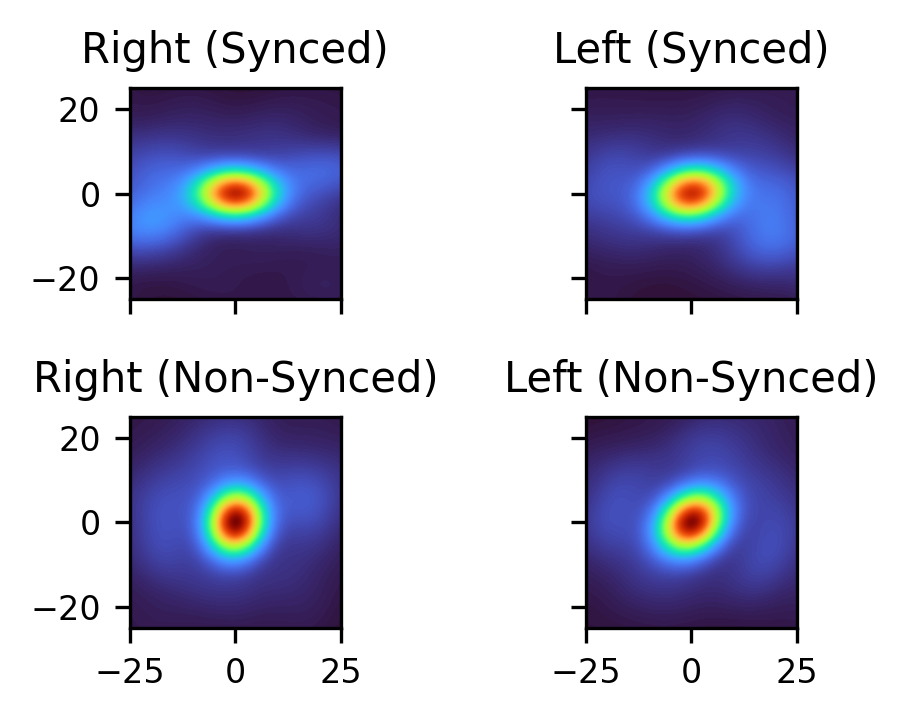

In [19]:
export_path = pathlib.Path(
    r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\saccade_heatmaps_degree_verified')
plot_saccade_heatmaps_comparison_trajectories(synced_saccade_collection.query('animal=="PV_57"'),
                                              non_synced_saccade_collection.query('animal=="PV_57"'), block_dict,
                                              export_path=None, nbins=200,
                                              global_min=-25, global_max=25,
                                              cmap=plt.cm.turbo, figsize=(4, 2.5))

482it [00:00, 1292.14it/s]
482it [00:00, 1308.84it/s]
1467it [00:01, 1289.11it/s]
583it [00:00, 1325.44it/s]


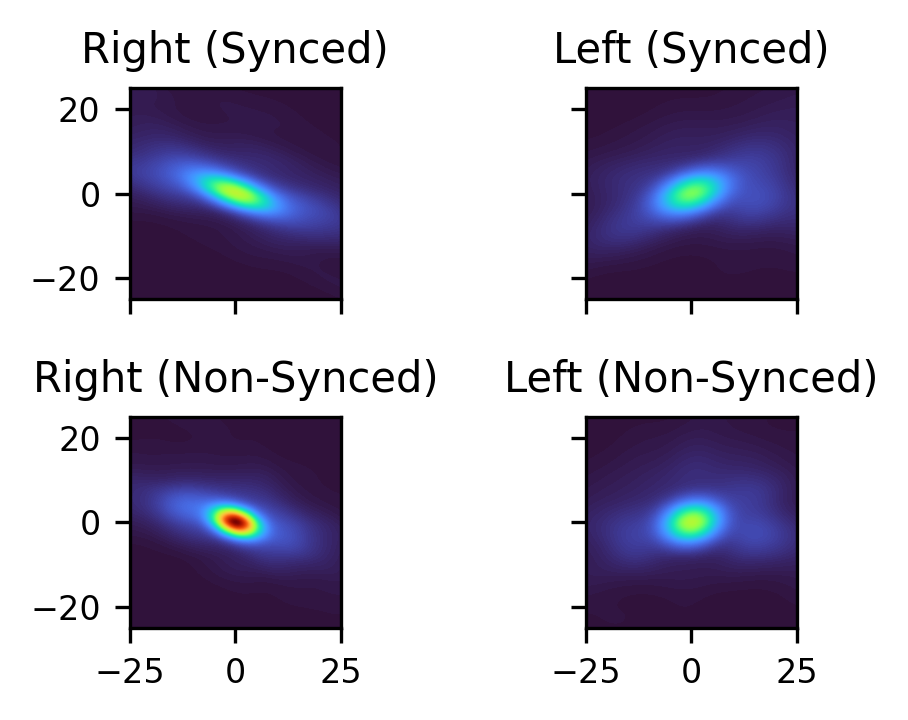

In [13]:
export_path = pathlib.Path(
    r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\saccade_heatmaps_degree_verified')
plot_saccade_heatmaps_comparison_trajectories(synced_saccade_collection.query('animal=="PV_57"'),
                                              non_synced_saccade_collection.query('animal=="PV_57"'), block_dict,
                                              export_path=None, nbins=200,
                                              global_min=-25, global_max=25,
                                              cmap=plt.cm.turbo, figsize=(4, 2.5))

NameError: name 'block' is not defined